- the idea was to compute a year where the equilibrium is reached, the problem is that the different models vary strongly in their interannual/decadal variability, even after doing a rolling average over 20 years.
- For some models, it is very "easy" to compute that year, for others, the thresholds would need to be set manually ...
- for the moment, I would prefer to use the 90% "response time", but there, I should properly check that it is really the last year where this threshold is reached ... 

In [3]:
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Jun29' #'apr04' (has OGGM runaway effect of glaciers inside)
fill_option = 'repeat_last_20yrs'
    

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

try:
    path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

except:
    path_merged_runs_scaled = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    # we don' want to have the extended dataset to get the equilibrium values ... 
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
    ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)

# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)

In [5]:
from help_func import pal_models, model_order, d_reg_num_name, model_order_anonymous
# remove OGGM_v153 and Huss
hue_order_anonymous = []
hue_order = model_order[:-2] 
glac_models = hue_order 
pal_models = pal_models[:-2]
pal_models = sns.color_palette(pal_models)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])

print(hue_order, hue_order_anonymous)
pal_models



['Rounce', 'Compagno', 'Zekollari', 'OGGM_v16', 'OGGM-VAS', 'GLIMB', 'Kraaijenbrink', 'James', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8', 'model 9']


[(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744)]

In [6]:
# test without Zeokllari and OGGM-VAS
sel = False
if sel:
    glac_models = ['James', 'Rounce', 'Compagno', 'Kraaijenbrink', 'GLIMB', 'OGGM_v16'] #, 'OGGM-VAS', 'Zekollari'] # OGGM_v153, Huss
    ds_reg_models = ds_reg_models.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

    # Let's take the median estimate from all glacier models for every RGI region and then do the sum:
else:    
    ds_reg_models = ds_reg_models.sel(model_author=glac_models)
    ds_reg_models_extend = ds_reg_models_extend.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']
    ds_reg_models_extend_vol = ds_reg_models_extend.volume_m3
# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_models_extend_vol = ds_reg_models_extend_vol.stack(experiments=['gcm','period_scenario'])

ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


In [56]:
# true for all
init_vol = ds_reg_models_vol.isel(simulation_year=0)
ds_reg_models_vol_roll = 100*ds_reg_models_vol.rolling(simulation_year=20, center=True).mean()/init_vol
ds_reg_models_vol_extend_roll = 100*ds_reg_models_extend_vol.rolling(simulation_year=20, center=True).mean()/init_vol

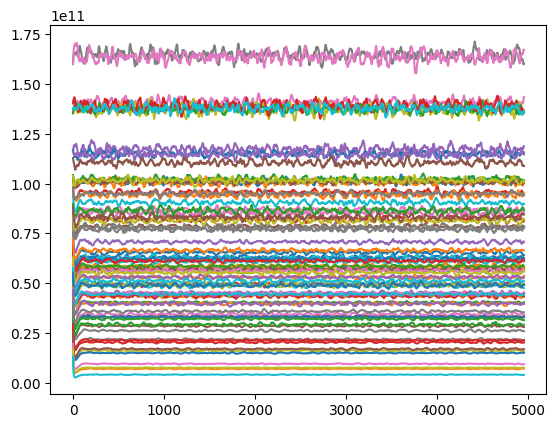

In [226]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=50,center=True).mean().sel(model_author='OGGM-VAS').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

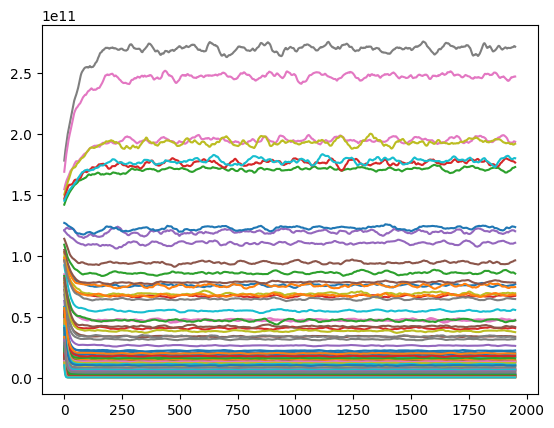

In [227]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=50,center=True).mean().sel(model_author='OGGM_v16').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

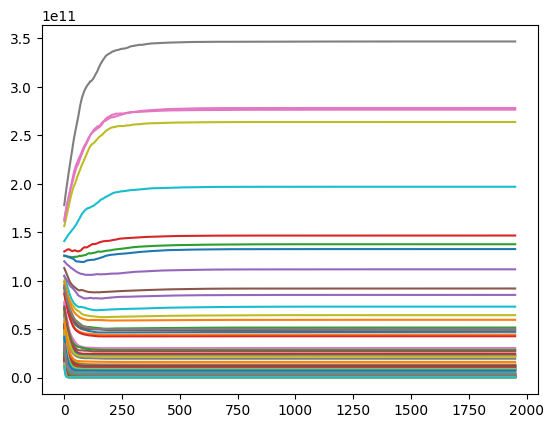

In [228]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=50,center=True).mean().sel(model_author='Rounce').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

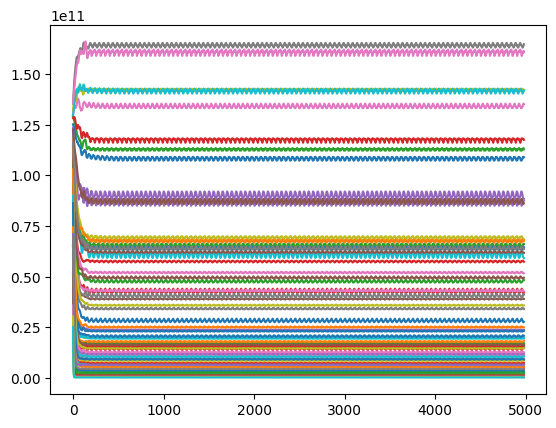

In [235]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='Compagno').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

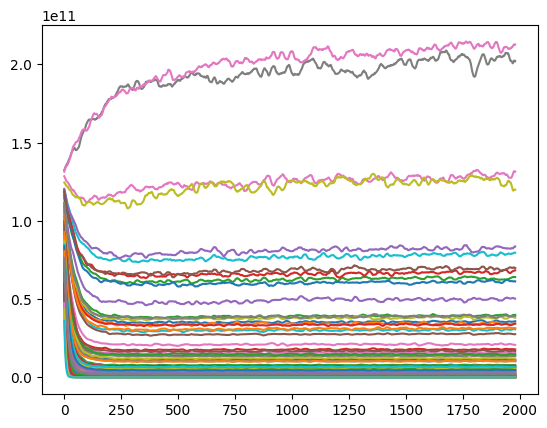

In [237]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='CISM2').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

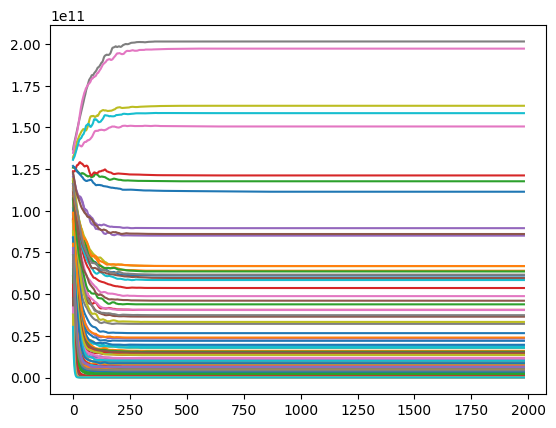

In [239]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='Zekollari').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

### We can still try to compute the equilibrium year, but it does not work for some models 

In [209]:
# let's do a loop, maybe there is an easier way, but it does not matter too much 
pd_l = []
for rgi_reg in ds_reg_models_vol.rgi_reg.values:
    for model in ds_reg_models_vol.model_author.values:
        
        ds_sel = ds_reg_models_vol_roll.sel(model_author=model).sel(rgi_reg=rgi_reg).dropna(dim='simulation_year')
        #pd_ll = []
        for xperc in [1]:
            if len(ds_sel.simulation_year)==0:
                # just set NaN values everywhere
                equilibrium_yr_lower_xperc_ch = pd.DataFrame(index=ds_sel.experiments.to_dataframe().index, 
                     columns=['simulation_year'],
                     )['simulation_year']
            else:
                end_yr = ds_sel.simulation_year[-1].values
                begin_yr = ds_sel.simulation_year[0].values
                total_change = np.abs(100 - ds_sel.sel(simulation_year=end_yr))
                # minimum is 33yrs in region 16, so maybe ok to use a 
                testi = ds_sel.sel(simulation_year=slice(20+begin_yr,end_yr))
                # important to set here values, as we do not want to substract the same years!!!
                testi_b = ds_sel.sel(simulation_year=slice(begin_yr,end_yr-20)).values
                # (V_roll(t) - V_roll(t-50) )/(2*((V_roll(t) + V_roll(t-50) ))
                # v_diff_20_yr = 100*np.abs((testi-testi_b))/(0.5*(testi+testi_b))
                # divide instead by total_change (otherwise we do have a problem if the volume gets very small... )
                # on the other hand, if total chane is small, we also get an issue 
                # v_diff_20_yr = 100*np.abs((testi-testi_b))/total_change
                # lets only do the difference 
                v_diff_20_yr = np.abs((testi-testi_b)) #/total_change

                v_diff_20_yr = v_diff_20_yr.reset_coords()

                # for that we select the last average year where the difference is above xperc% 
                v_diff_20_yr_abovexperc = v_diff_20_yr.volume_m3.where(v_diff_20_yr.volume_m3>xperc).to_dataframe('volume_diff_after_20_yrs').dropna()
                v_diff_20_yr_abovexperc = v_diff_20_yr_abovexperc.drop(columns=['period_scenario','gcm'])
                v_diff_20_yr_abovexperc = v_diff_20_yr_abovexperc.reset_index()
                #v_diff_20_yr_above1perc['experiments'] = v_diff_20_yr_above1perc['period_scenario'] + '_'+ v_diff_20_yr_1perc['gcm']

                v_diff_20_yr_last_yr_above_xperc = v_diff_20_yr_abovexperc.groupby(['gcm', 'period_scenario']).max()['simulation_year']

                # if it is the end of the timeseries (i.e. 1990 or 4990), it means that no equilibrium within the limits was reached , we set it to np.NaN
                #print(end_yr)
                # for the moment just set a larger number and then we need to check what to do!
                v_diff_20_yr_last_yr_above_xperc.loc[v_diff_20_yr_last_yr_above_xperc>=end_yr] = 100000
                # we need to add +1 (as we computed the last year where it was above 1)
                equilibrium_yr_lower_xperc_ch = v_diff_20_yr_last_yr_above_xperc + 1

                #print(v_diff_20_yr)
            # create pandas dataframe that can be concatenated ... 
            pd_equilibrium_yr_lower_xperc_ch = pd.DataFrame(equilibrium_yr_lower_xperc_ch).rename(columns={'simulation_year':f'simulation_yr_where_equilibrium_lower_{xperc}perc_ch_reached'})

            pd_equilibrium_yr_lower_xperc_ch['rgi_reg'] = rgi_reg
            pd_equilibrium_yr_lower_xperc_ch['model'] = model

            # for those experiments, we need to check the extended time series ... 
            #pd_equilibrium_yr_lower_1perc_ch.loc[pd_equilibrium_yr_lower_1perc_ch['simulation_yr_where_equilibrium_lower_1perc_ch_reached'].isna()]
        pd_l.append(pd_equilibrium_yr_lower_xperc_ch)
pd_equilibrium_yr_lower_xperc_ch = pd.concat(pd_l)

In [210]:
pd_equilibrium_yr_lower_xperc_ch

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm         period_scenario                                                           
gfdl-esm4   1851-1870_hist                                                  210       
            1901-1920_hist                                                  221       
            1951-1970_hist                                                  217       
            1995-2014_hist                                                  219       
            2021-2040_ssp126                                                190       
...                                                                         ...       
ukesm1-0-ll 2061-2080_ssp370                                                NaN       
            2061-2080_ssp585                                                NaN       
            2081-2100_ssp126                                                NaN       
            2081-2100_ssp370                                                NaN       
            2081-2100_ssp585                                                NaN       

                             rgi_reg   model  
gcm         period_scenario                   
gfdl-esm4   1851-1870_hist        01  Rounce  
            1901-1920_hist        01  Rounce  
            1951-1970_hist        01  Rounce  
            1995-2014_hist        01  Rounce  
            2021-2040_ssp126      01  Rounce  
...                              ...     ...  
ukesm1-0-ll 2061-2080_ssp370      19   CISM2  
            2061-2080_ssp585      19   CISM2  
            2081-2100_ssp126      19   CISM2  
            2081-2100_ssp370      19   CISM2  
            2081-2100_ssp585      19   CISM2  

[13497 rows x 3 columns]

In [211]:
pd_equilibrium_yr_lower_1perc_ch = pd_equilibrium_yr_lower_1perc_ch.sort_values(by='simulation_yr_where_equilibrium_lower_1perc_ch_reached')

In [212]:
pd_equilibrium_yr_lower_1perc_ch.dropna()

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm           period_scenario                                                           
ukesm1-0-ll   2081-2100_ssp585                                                 33       
              2081-2100_ssp585                                                 33       
ipsl-cm6a-lr  2081-2100_ssp585                                                 34       
              2081-2100_ssp585                                                 34       
ukesm1-0-ll   2081-2100_ssp370                                                 34       
...                                                                           ...       
ipsl-cm6a-lr  1995-2014_hist                                               100001       
mpi-esm1-2-hr 2021-2040_ssp585                                             100001       
mri-esm2-0    1951-1970_hist                                               100001       
mpi-esm1-2-hr 1851-1870_hist                                               100001       
gfdl-esm4     1951-1970_hist                                               100001       

                               rgi_reg     model  
gcm           period_scenario                     
ukesm1-0-ll   2081-2100_ssp585      16  Compagno  
              2081-2100_ssp585      16  OGGM_v16  
ipsl-cm6a-lr  2081-2100_ssp585      16  OGGM_v16  
              2081-2100_ssp585      16  Compagno  
ukesm1-0-ll   2081-2100_ssp370      16  OGGM_v16  
...                                ...       ...  
ipsl-cm6a-lr  1995-2014_hist        11     GLIMB  
mpi-esm1-2-hr 2021-2040_ssp585      08  OGGM-VAS  
mri-esm2-0    1951-1970_hist        07     GLIMB  
mpi-esm1-2-hr 1851-1870_hist        11     GLIMB  
gfdl-esm4     1951-1970_hist        11  OGGM_v16  

[8480 rows x 3 columns]

In [213]:
pd_equilibrium_yr_lower_1perc_ch.loc[pd_equilibrium_yr_lower_1perc_ch.simulation_yr_where_equilibrium_lower_1perc_ch_reached ==100001]

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm           period_scenario                                                           
mri-esm2-0    1901-1920_hist                                               100001       
gfdl-esm4     1851-1870_hist                                               100001       
mpi-esm1-2-hr 1851-1870_hist                                               100001       
              1951-1970_hist                                               100001       
              1901-1920_hist                                               100001       
...                                                                           ...       
ipsl-cm6a-lr  1995-2014_hist                                               100001       
mpi-esm1-2-hr 2021-2040_ssp585                                             100001       
mri-esm2-0    1951-1970_hist                                               100001       
mpi-esm1-2-hr 1851-1870_hist                                               100001       
gfdl-esm4     1951-1970_hist                                               100001       

                               rgi_reg     model  
gcm           period_scenario                     
mri-esm2-0    1901-1920_hist        10  OGGM_v16  
gfdl-esm4     1851-1870_hist        10  OGGM-VAS  
mpi-esm1-2-hr 1851-1870_hist        17  OGGM_v16  
              1951-1970_hist        17  OGGM_v16  
              1901-1920_hist        17  OGGM_v16  
...                                ...       ...  
ipsl-cm6a-lr  1995-2014_hist        11     GLIMB  
mpi-esm1-2-hr 2021-2040_ssp585      08  OGGM-VAS  
mri-esm2-0    1951-1970_hist        07     GLIMB  
mpi-esm1-2-hr 1851-1870_hist        11     GLIMB  
gfdl-esm4     1951-1970_hist        11  OGGM_v16  

[1704 rows x 3 columns]

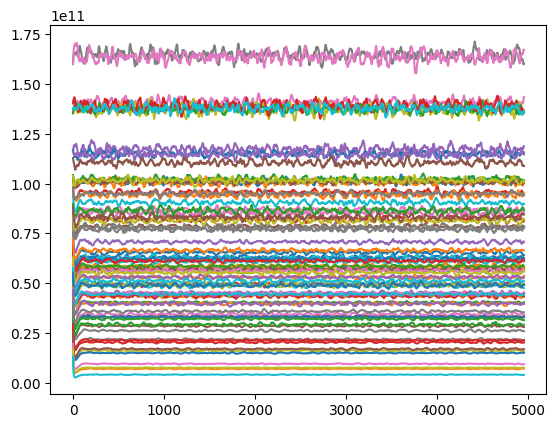

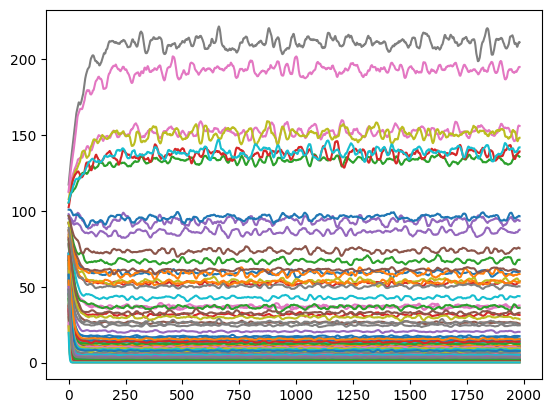

In [220]:
ds_sel = ds_reg_models_vol_roll.sel(model_author='OGGM_v16').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

In [214]:
pd_equilibrium_yr_lower_1perc_ch.where(pd_equilibrium_yr_lower_1perc_ch['simulation_yr_where_equilibrium_lower_1perc_ch_reached'].isna())#.dropna()

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm          period_scenario                                                           
ukesm1-0-ll  2081-2100_ssp585                                                NaN       
             2081-2100_ssp585                                                NaN       
ipsl-cm6a-lr 2081-2100_ssp585                                                NaN       
             2081-2100_ssp585                                                NaN       
ukesm1-0-ll  2081-2100_ssp370                                                NaN       
...                                                                          ...       
             2061-2080_ssp370                                                NaN       
             2061-2080_ssp585                                                NaN       
             2081-2100_ssp126                                                NaN       
             2081-2100_ssp370                                                NaN       
             2081-2100_ssp585                                                NaN       

                              rgi_reg  model  
gcm          period_scenario                  
ukesm1-0-ll  2081-2100_ssp585     NaN    NaN  
             2081-2100_ssp585     NaN    NaN  
ipsl-cm6a-lr 2081-2100_ssp585     NaN    NaN  
             2081-2100_ssp585     NaN    NaN  
ukesm1-0-ll  2081-2100_ssp370     NaN    NaN  
...                               ...    ...  
             2061-2080_ssp370      19  CISM2  
             2061-2080_ssp585      19  CISM2  
             2081-2100_ssp126      19  CISM2  
             2081-2100_ssp370      19  CISM2  
             2081-2100_ssp585      19  CISM2  

[13680 rows x 3 columns]

In [67]:
# actually we don't need that here anymore 
#v_diff_20_yr_1perc = v_diff_20_yr.volume_m3.where(v_diff_20_yr.volume_m3<=1).to_dataframe('volume_diff_after_20_yrs').dropna()
#v_diff_20_yr_1perc = v_diff_20_yr_1perc.drop(columns=['period_scenario','gcm'])
#v_diff_20_yr_1perc = v_diff_20_yr_1perc.reset_index()
#v_diff_20_yr_1perc['experiments'] = v_diff_20_yr_1perc['period_scenario'] + '_'+ v_diff_20_yr_1perc['gcm']
# this is the minimum year where equilibrium might be reached
#v_diff_20_yr_1perc_pot_eq_yr = v_diff_20_yr_1perc.groupby(['gcm', 'period_scenario']).min()['simulation_year']

In [72]:
pd_equilibrium_yr_lower_1perc_ch

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm         period_scenario                                                            
gfdl-esm4   1851-1870_hist                                                255.0        
            1901-1920_hist                                               1749.0        
            1951-1970_hist                                                619.0        
            1995-2014_hist                                                200.0        
            2021-2040_ssp126                                               86.0        
...                                                                         ...        
ukesm1-0-ll 2061-2080_ssp370                                               48.0        
            2061-2080_ssp585                                               45.0        
            2081-2100_ssp126                                               65.0        
            2081-2100_ssp370                                               43.0        
            2081-2100_ssp585                                               41.0        

                             rgi_reg   model  
gcm         period_scenario                   
gfdl-esm4   1851-1870_hist        11  Rounce  
            1901-1920_hist        11  Rounce  
            1951-1970_hist        11  Rounce  
            1995-2014_hist        11  Rounce  
            2021-2040_ssp126      11  Rounce  
...                              ...     ...  
ukesm1-0-ll 2061-2080_ssp370      11  Rounce  
            2061-2080_ssp585      11  Rounce  
            2081-2100_ssp126      11  Rounce  
            2081-2100_ssp370      11  Rounce  
            2081-2100_ssp585      11  Rounce  

[80 rows x 3 columns]

In [51]:
equilibrium_yr_lower_1perc_ch

gcm          period_scenario 
gfdl-esm4    1851-1870_hist       255.0
             1901-1920_hist      1749.0
             1951-1970_hist       619.0
             1995-2014_hist       200.0
             2021-2040_ssp126      86.0
                                  ...  
ukesm1-0-ll  2061-2080_ssp370      48.0
             2061-2080_ssp585      45.0
             2081-2100_ssp126      65.0
             2081-2100_ssp370      43.0
             2081-2100_ssp585      41.0
Name: simulation_year, Length: 80, dtype: float64

In [47]:
ds_equilibrium_yr_lower_1perc_ch = to_xarray()

In [50]:
ds_equilibrium_yr_lower_1perc_ch

<xarray.Dataset>
Dimensions:                                                 (gcm: 5,
                                                             period_scenario: 16)
Coordinates:
  * gcm                                                     (gcm) object 'gfd...
  * period_scenario                                         (period_scenario) object ...
Data variables:
    simulation_yr_where_equilibrium_lower_1perc_ch_reached  (gcm, period_scenario) float64 ...

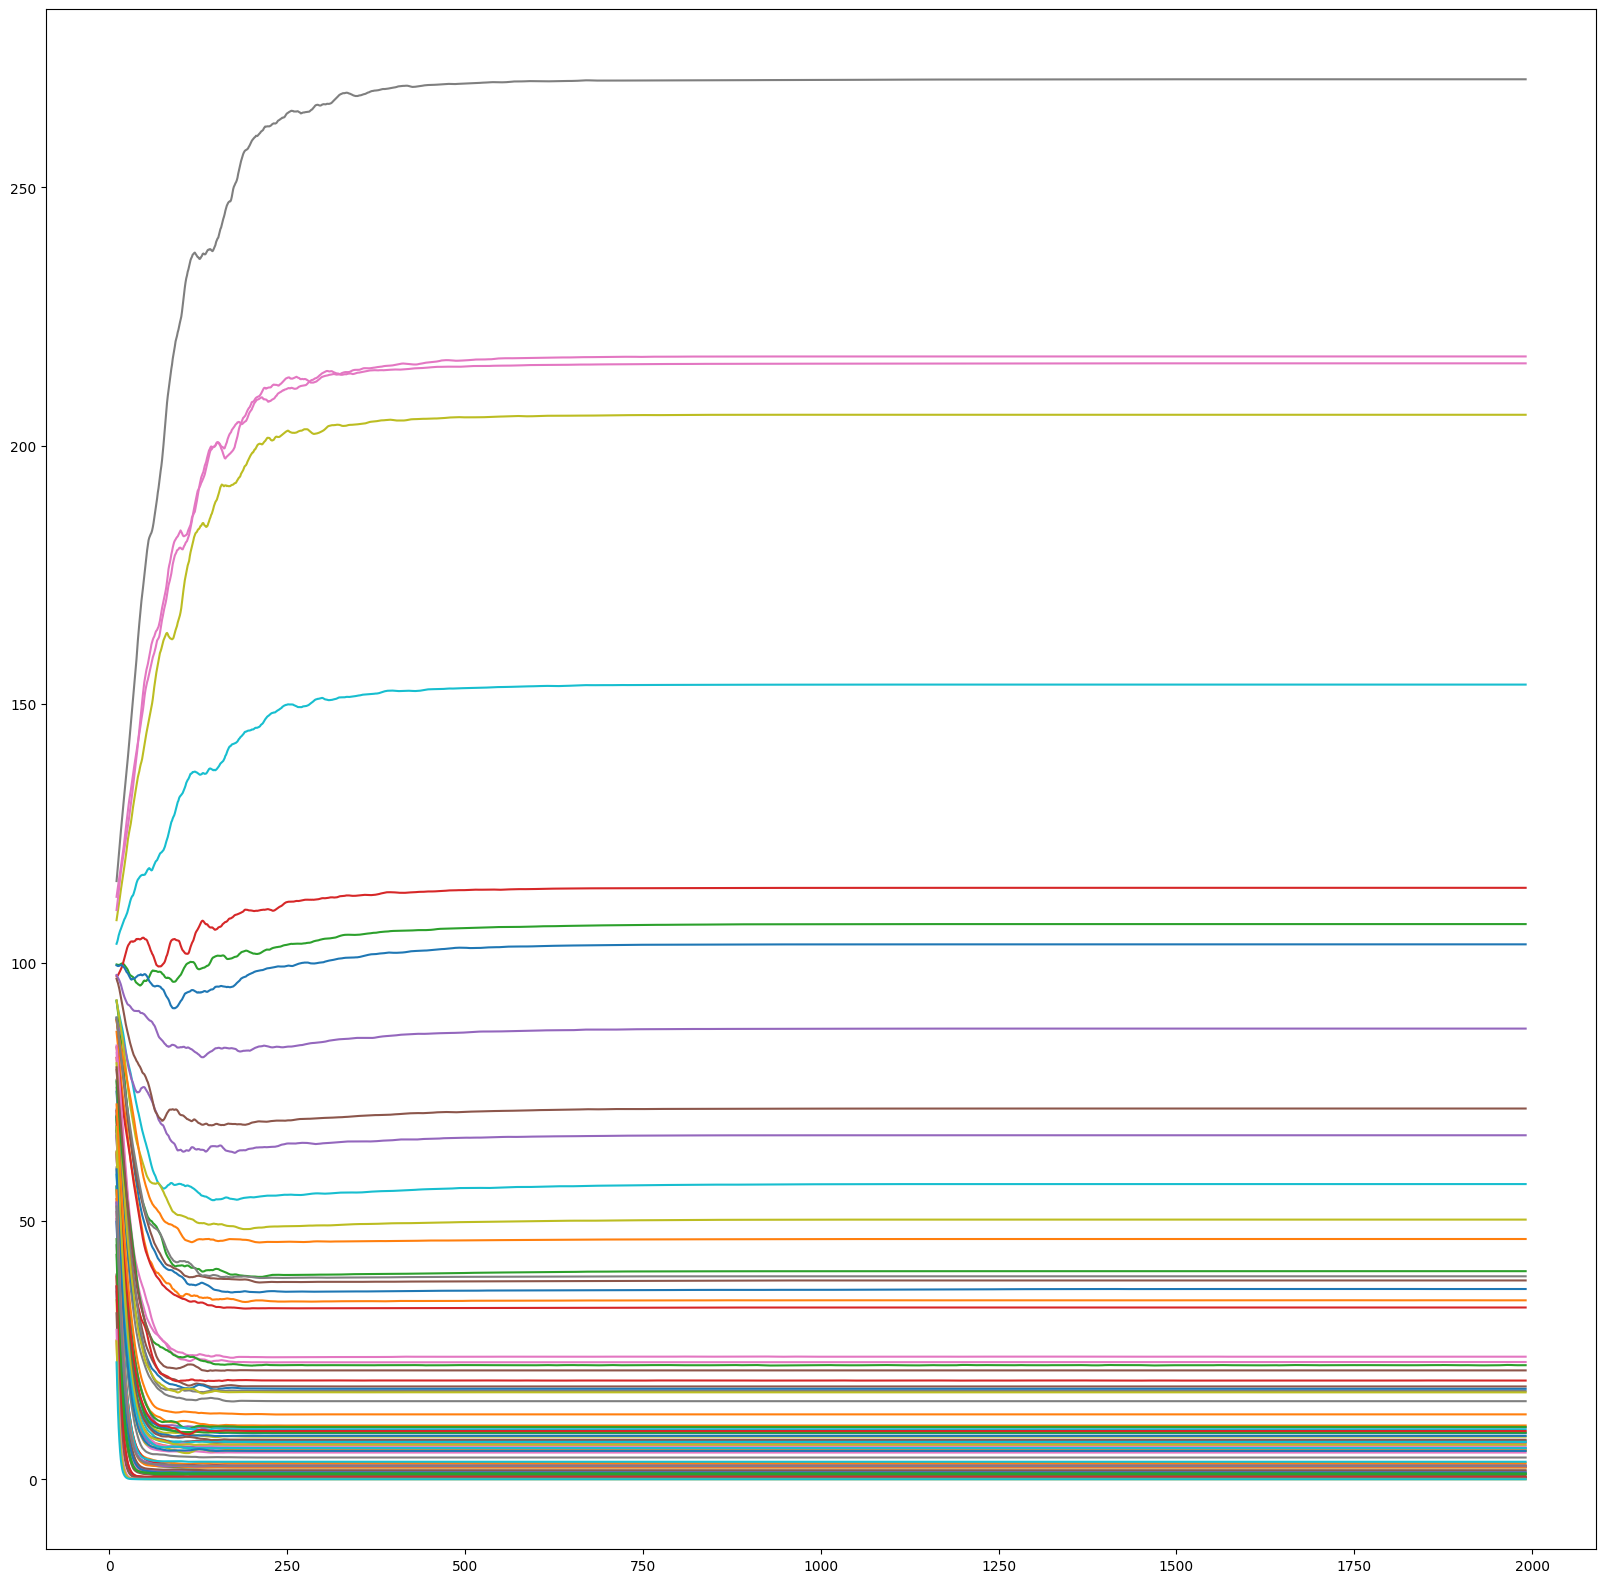

In [26]:
plt.figure(figsize=(20,20))
plt.plot(ds_reg_models_vol_roll.sel(rgi_reg='11').isel(model_author=0).isel(simulation_year=slice(0,2000)));

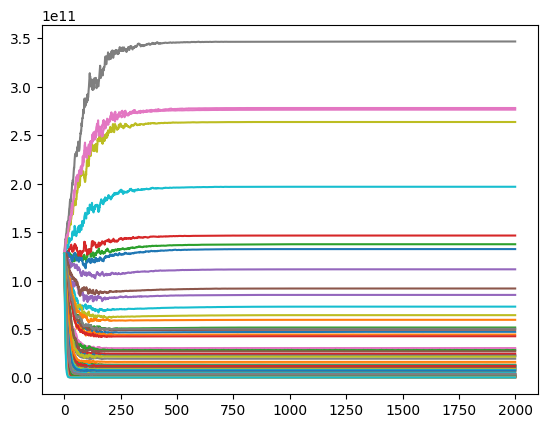

In [ ]:
plt.plot()

In [146]:
v_diff_20_yr_last_yr_above_1perc+1

experiments
1851-1870_hist_gfdl-esm4           219
1851-1870_hist_ipsl-cm6a-lr        220
1851-1870_hist_mpi-esm1-2-hr       230
1851-1870_hist_mri-esm2-0          234
1851-1870_hist_ukesm1-0-ll         248
                                  ... 
2081-2100_ssp585_gfdl-esm4        1469
2081-2100_ssp585_ipsl-cm6a-lr     1472
2081-2100_ssp585_mpi-esm1-2-hr     159
2081-2100_ssp585_mri-esm2-0        160
2081-2100_ssp585_ukesm1-0-ll       177
Name: simulation_year, Length: 80, dtype: int64

In [144]:
# those years where the difference gets again above 1 % above are now updated by the yr where the difference is the last time above 1 perc 
v_diff_20_yr_1perc_pot_eq_yr.loc[v_diff_20_yr_1perc_pot_eq_yr <v_diff_20_yr_last_yr_above_1perc] = 

experiments
1851-1870_hist_gfdl-esm4          128
1851-1870_hist_ipsl-cm6a-lr       160
1851-1870_hist_mpi-esm1-2-hr       52
1851-1870_hist_mri-esm2-0         142
1851-1870_hist_ukesm1-0-ll         98
                                 ... 
2081-2100_ssp585_gfdl-esm4         83
2081-2100_ssp585_ipsl-cm6a-lr      81
2081-2100_ssp585_mpi-esm1-2-hr     85
2081-2100_ssp585_mri-esm2-0       116
2081-2100_ssp585_ukesm1-0-ll       84
Name: simulation_year, Length: 80, dtype: int64

In [138]:
v_diff_20_yr_last_yr_above_1perc

experiments
1851-1870_hist_gfdl-esm4           218
1851-1870_hist_ipsl-cm6a-lr        219
1851-1870_hist_mpi-esm1-2-hr       229
1851-1870_hist_mri-esm2-0          233
1851-1870_hist_ukesm1-0-ll         247
                                  ... 
2081-2100_ssp585_gfdl-esm4        1468
2081-2100_ssp585_ipsl-cm6a-lr     1471
2081-2100_ssp585_mpi-esm1-2-hr     158
2081-2100_ssp585_mri-esm2-0        159
2081-2100_ssp585_ukesm1-0-ll       176
Name: simulation_year, Length: 80, dtype: int64

In [132]:
v_diff_20_yr.simulation_year

<xarray.DataArray 'simulation_year' (simulation_year: 1981)>
array([  20,   21,   22, ..., 1998, 1999, 2000], dtype=int16)
Coordinates:
  * simulation_year  (simulation_year) int16 20 21 22 23 ... 1997 1998 1999 2000

In [131]:
v_diff_20_yr.simulation_year.where(v_diff_20_yr.simulation_year>=v_diff_20_yr_1perc_pot_eq_yr.simulation_year)

ValueError: ('Lengths must match to compare', (80,), (1981,))

In [70]:
# everything that is below 0.01% is definitely in equilibrium 
v_diff_20_yr_1perc['volume_diff_after_20_yrs']

0         0.882298
1         0.480449
2         0.417839
3         0.355112
4         0.004430
            ...   
147338    0.400154
147339    0.000000
147340    0.007780
147341    0.000000
147342    0.000000
Name: volume_diff_after_20_yrs, Length: 147343, dtype: float32

,simulation_year,gcm,model_author,rgi_reg,volume_diff_after_20_yrs
period_scenario,,,,,
1851-1870_hist,52,gfdl-esm4,Rounce,11,0.000000
1901-1920_hist,49,gfdl-esm4,Rounce,11,0.000000
1951-1970_hist,43,gfdl-esm4,Rounce,11,0.000000
1995-2014_hist,87,gfdl-esm4,Rounce,11,0.000000
2021-2040_ssp126,90,gfdl-esm4,Rounce,11,0.000000
2021-2040_ssp370,88,gfdl-esm4,Rounce,11,0.000000
2021-2040_ssp585,91,gfdl-esm4,Rounce,11,0.000000
2041-2060_ssp126,85,gfdl-esm4,Rounce,11,0.000000
2041-2060_ssp370,83,gfdl-esm4,Rounce,11,0.000000


In [58]:
v_diff_20_yr_1perc

model_author rgi_reg  \
simulation_year gcm         period_scenario                         
20              gfdl-esm4   1851-1870_hist         Rounce      11   
                            1901-1920_hist         Rounce      11   
                            1951-1970_hist         Rounce      11   
                            1995-2014_hist         Rounce      11   
                            2021-2040_ssp126       Rounce      11   
...                                                   ...     ...   
2000            ukesm1-0-ll 2061-2080_ssp370       Rounce      11   
                            2061-2080_ssp585       Rounce      11   
                            2081-2100_ssp126       Rounce      11   
                            2081-2100_ssp370       Rounce      11   
                            2081-2100_ssp585       Rounce      11   

                                                      gcm   period_scenario  \
simulation_year gcm         period_scenario                                   
20              gfdl-esm4   1851-1870_hist      gfdl-esm4    1851-1870_hist   
                            1901-1920_hist      gfdl-esm4    1901-1920_hist   
                            1951-1970_hist      gfdl-esm4    1951-1970_hist   
                            1995-2014_hist      gfdl-esm4    1995-2014_hist   
                            2021-2040_ssp126    gfdl-esm4  2021-2040_ssp126   
...                                                   ...               ...   
2000            ukesm1-0-ll 2061-2080_ssp370  ukesm1-0-ll  2061-2080_ssp370   
                            2061-2080_ssp585  ukesm1-0-ll  2061-2080_ssp585   
                            2081-2100_ssp126  ukesm1-0-ll  2081-2100_ssp126   
                            2081-2100_ssp370  ukesm1-0-ll  2081-2100_ssp370   
                            2081-2100_ssp585  ukesm1-0-ll  2081-2100_ssp585   

                                              volume_diff_after_20_yrs  
simulation_year gcm         period_scenario                             
20              gfdl-esm4   1851-1870_hist                         NaN  
                            1901-1920_hist                         NaN  
                            1951-1970_hist                         NaN  
                            1995-2014_hist                         NaN  
                            2021-2040_ssp126                       NaN  
...                                                                ...  
2000            ukesm1-0-ll 2061-2080_ssp370                       NaN  
                            2061-2080_ssp585                       NaN  
                            2081-2100_ssp126                       NaN  
                            2081-2100_ssp370                       NaN  
                            2081-2100_ssp585                       NaN  

[158480 rows x 5 columns]

In [45]:
v_diff_50_yr_1perc = v_diff_50_yr.where(v_diff_50_yr<=1).to_dataframe('volume_diff_after_50_yrs')#.dropna()

In [48]:
v_diff_50_yr_1perc

,model_author,rgi_reg,simulation_year,gcm,period_scenario,volume_diff_after_50_yrs
0,Rounce,01,50,gfdl-esm4,1851-1870_hist,NaN
1,Rounce,01,50,gfdl-esm4,1901-1920_hist,NaN
2,Rounce,01,50,gfdl-esm4,1951-1970_hist,NaN
3,Rounce,01,50,gfdl-esm4,1995-2014_hist,NaN
4,Rounce,01,50,gfdl-esm4,2021-2040_ssp126,NaN
...,...,...,...,...,...,...
26689675,CISM2,19,2000,ukesm1-0-ll,2061-2080_ssp370,NaN
26689676,CISM2,19,2000,ukesm1-0-ll,2061-2080_ssp585,NaN
26689677,CISM2,19,2000,ukesm1-0-ll,2081-2100_ssp126,NaN
26689678,CISM2,19,2000,ukesm1-0-ll,2081-2100_ssp370,NaN
